In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import datetime
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from matplotlib.dates import DateFormatter, DayLocator, HourLocator

# Read in the data, check for GPS messages and establish number of measurements and cells
Put a path to your DCPS text file here

In [2]:
adcp_raw = pd.read_csv("/home/callum/Downloads/glider_data/SB_DATA/SAMBA_001/SB_VOTO_ADCP/20200915/DCPS.TXT", names=["message"])

In [3]:
starts, measures, ends = 0, 0, 0
for msg in adcp_raw.message:
    if "opened" in msg:
        starts+=1
    if "MEASUREMENT" in msg:
        measures+=1
        measure_msg = msg
    if "closed" in msg:
        ends+=1   
if starts!= measures or ends!= measures:
    print(f"Warning! number of gps starts {starts} or gps ends {ends} does not match number of ADCP data points {measures}")
else:
    print(f"{measures} measurements in input file")
num_times = measures
measure_list = measure_msg.split("\t")[3:]
keys, vals = measure_list[::2], measure_list[1::2]

1028 measurements in input file


### Split input data
Each variable has dimensions of time only (GPS position, SailBuoy pitch) or dimensions of time and cell number (e.g. ADCP heading)

In [4]:
# Find split between profile variables and cell variables by finding first occurence of cell
for i, key in enumerate(keys):
    if "Cell" in key:
        start_cells = i
        break
profile_vars = keys[:i]
cell_vars = tuple(set(keys[i:]))

In [5]:
# Count number of cells
c = Counter(keys)
num_cells = c.most_common(1)[0][1]
cell_ids = np.arange(num_cells)
print(f"ADCP data comprised of {num_cells} cells")

ADCP data comprised of 30 cells


In [6]:
# Helper function to pasrse GPS sentences
def parse_gps_str(gps_str):
    parts = gps_str.split(" ")
    datetime_str = f"{parts[-4]} {parts[-3]}" 
    time = parts[-3]
    lat = parts[-2]
    lon = parts[-1]
    gps_datetime = datetime.datetime.strptime(datetime_str, "%d.%m.%Y %H:%M:%S")
    return gps_datetime, lat, lon


# Create empty arrays for our variables

In [7]:
# Create empty arrays for observations. We use number of measurements and number of cells as dimensions
profile_dict, cell_dict = {}, {}
profile_array = np.empty(num_times, dtype=float)
profile_array[:] = np.nan
cell_array = np.empty((num_cells, num_times), dtype=float)
cell_array[:] = np.nan

# Add all values from measurements
for var in profile_vars:
    profile_dict[var] = profile_array.copy()

for var in cell_vars:
    cell_dict[var] = cell_array.copy()

# Add GPS times
time_array = np.empty(num_times, dtype=datetime.datetime)
time_array[:] = datetime.datetime(1970,1,1)
profile_dict["time_start"] = time_array.copy()
profile_dict["lat_start"] = profile_array.copy()
profile_dict["lon_start"] = profile_array.copy()
profile_dict["time_end"] = time_array.copy()
profile_dict["lat_end"] = profile_array.copy()
profile_dict["lon_end"] = profile_array.copy()

# Extra items that sometimes appear in data. Bad data flags or something?
cell_dict['*Horizontal Speed[cm/s]'] = cell_array.copy()
cell_dict['*Direction[Deg.M]'] = cell_array.copy()

# Run through the data file and extract the data into our pre-made arrays


In [8]:
t = -1
for msg in adcp_raw.message:
    if "opened" in msg:
        t+=1
        gps_start_msg = msg
        gps_dt, lat, lon = parse_gps_str(gps_start_msg)
        profile_dict["time_start"][t] = gps_dt
        profile_dict["lat_start"][t] = lat
        profile_dict["lon_start"][t] = lon
    if "MEASUREMENT" in msg:
        measure_msg = msg
        measure_list = measure_msg.split("\t")[3:]
        keys, vals = measure_list[::2], measure_list[1::2]
        c = -1
        for key, val in zip(keys, vals):
            if key == "Cell Index":
                c+=1
            if key in profile_dict.keys():
                profile_dict[key][t] = val
            else:
                cell_dict[key][c, t] = val
    if "closed" in msg:
        gps_close_msg = msg
        gps_dt, lat, lon = parse_gps_str(gps_close_msg)
        profile_dict["time_end"][t] = gps_dt
        profile_dict["lat_end"][t] = lat
        profile_dict["lon_end"][t] = lon

# Make pretty netCDFs
### Create xarray friendly dictionaries of our data with their dimensions


In [9]:
data_vars = {}
for key, val in profile_dict.items():
    data_vars[key] = (["time"], val)
for key, val in cell_dict.items():
    data_vars[key] = (["cells", "time"], val)

### Create the dataset


In [10]:
ds = xr.Dataset(
    data_vars=data_vars,
    coords=dict(
        cells=cell_ids,
        time=profile_dict["time_start"] ,
    ),
    attrs=dict(description="ADCP data munged data from a DCPS file. By Callum Rollo 2022-08-30"),
)

ds

<xarray.Dataset>
Dimensions:                  (time: 1028, cells: 30)
Coordinates:
  * cells                    (cells) int64 0 1 2 3 4 5 6 ... 24 25 26 27 28 29
  * time                     (time) datetime64[ns] 2020-08-24T12:07:34 ... 20...
Data variables: (12/29)
    Heading[Deg.M]           (time) float64 190.1 190.0 190.0 ... 255.1 214.9
    Std Dev Heading[Deg.M]   (time) float64 0.7503 0.8815 0.7242 ... 14.85 14.71
    Pitch[Deg]               (time) float64 -1.044 -1.07 -1.059 ... 2.744 1.654
    Roll[Deg]                (time) float64 178.9 178.9 179.0 ... -179.3 179.9
    Abs Tilt[Deg]            (time) float64 178.5 178.5 178.5 ... 171.8 173.1
    Max Tilt[Deg]            (time) float64 2.16 1.996 2.044 ... 30.77 21.02
    ...                       ...
    Horizontal Speed[cm/s]   (cells, time) float64 70.26 42.31 ... 126.5 99.14
    Cell Index               (cells, time) float64 1e+03 1e+03 ... 1.029e+03
    Cell State2              (cells, time) float64 -256.0 -256.0 ... 0.0 0.0
    Cell State1              (cells, time) float64 4.08e+03 1.776e+03 ... 192.0
    *Horizontal Speed[cm/s]  (cells, time) float64 nan nan nan ... nan nan nan
    *Direction[Deg.M]        (cells, time) float64 nan nan nan ... nan nan nan
Attributes:
    description:  ADCP data munged data from a DCPS file. By Callum Rollo 202...

# Examine data 

In [11]:
# get rid of the first few samples from bench testing (specific to this dataset)
ds = ds.sel(time=slice(ds.time.values[17], ds.time.values[-1]))

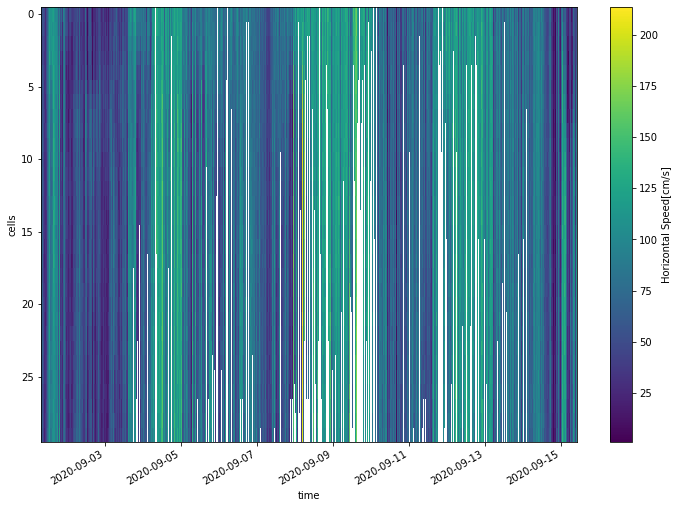

In [12]:
# Quick plot of horisontal speed
fig, ax = plt.subplots(figsize=(12, 8))
ds['Horizontal Speed[cm/s]'].plot(ax=ax)
ax.invert_yaxis()

### Subset the data for more in depth investigation

In [13]:
ds_sub = ds.sel(time=slice(ds.time.values[0], ds.time.values[100]))

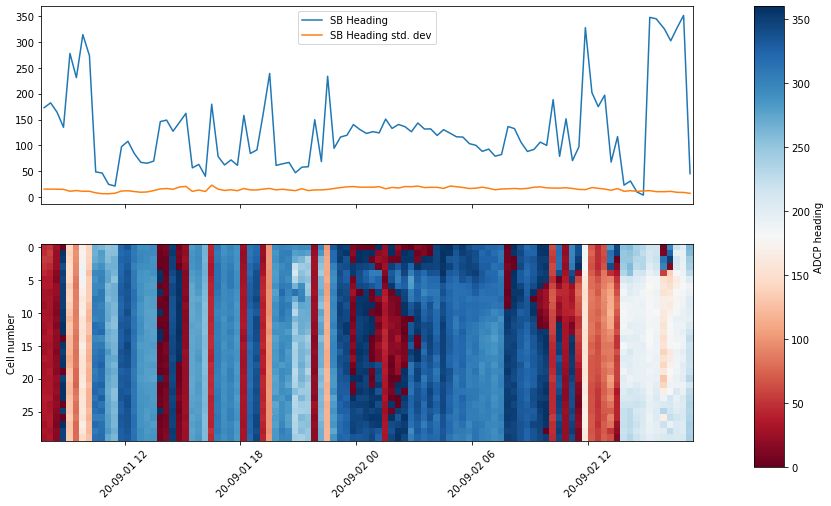

In [14]:
fig, ax = plt.subplots(2,1, figsize=(12, 8), sharex="col")
ax[0].plot(ds_sub.time, ds_sub['Heading[Deg.M]'], label="SB Heading")
ax[0].plot(ds_sub.time, ds_sub['Std Dev Heading[Deg.M]'], label="SB Heading std. dev")

ax[0].legend()
pcol = ax[1].pcolor(ds_sub.time, ds_sub.cells, ds_sub['Direction[Deg.M]'], vmin=0, vmax=360, cmap="RdBu")

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.95, 0.08, 0.035, 0.8])
fig.colorbar(pcol, cax=cbar_ax, label="ADCP heading");

ax[1].invert_yaxis()
ax[1].set(ylabel="Cell number")

ax[1].xaxis.set_major_locator(HourLocator((0, 6, 12, 18)))
ax[1].xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax[1].xaxis.set_tick_params(rotation=45)

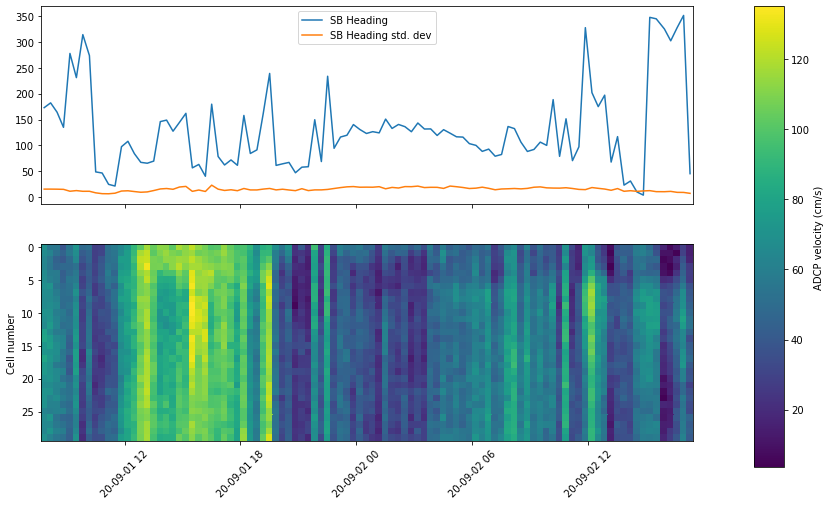

In [15]:
fig, ax = plt.subplots(2,1, figsize=(12, 8), sharex="col")
ax[0].plot(ds_sub.time, ds_sub['Heading[Deg.M]'], label="SB Heading")
ax[0].plot(ds_sub.time, ds_sub['Std Dev Heading[Deg.M]'], label="SB Heading std. dev")

ax[0].legend()
pcol = ax[1].pcolor(ds_sub.time, ds_sub.cells, ds_sub['Horizontal Speed[cm/s]'])

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.95, 0.08, 0.035, 0.8])
fig.colorbar(pcol, cax=cbar_ax, label="ADCP velocity (cm/s)");

ax[1].invert_yaxis()
ax[1].set(ylabel="Cell number")
ax[1].xaxis.set_major_locator(HourLocator((0, 6, 12, 18)))
ax[1].xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax[1].xaxis.set_tick_params(rotation=45)

--------------------------

# TODO
- establish vessel speed over ground from GPS start and end
- make netCDF pretty/CF compliant
- add proper units etc
- work out what the extra ADCP variables that begin in an asterisk are. Flagged bad perhaps?
- Pull in data from other sensors with timestamp matching for comparison, e.g. wave hight, wind speed etc.